# Spitzer-ulens Tutorial Notebook
This notebook aims to demonstrate the usage of the main functions in the Spitzer-ulens package.

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
%matplotlib inline

import pickle
import emcee
import time as ti
from tqdm import tqdm
import os
from multiprocessing import Pool
import corner

from Spitzer_ulens import data_config
from Spitzer_ulens.MuLensEvent import MuLensEvent
from Spitzer_ulens import models
from Spitzer_ulens import PLD
from Spitzer_ulens import plot
from Spitzer_ulens import mcmc

## Defining Variables
These can be modified for use with different events and different models.

In [21]:
EVENT_NAME = 'ob171140'
TELESCOPE = 'spitzer'
EVENT_COORDS = ('17:47:31.93','-24:31:21.6')
MODELFUNC = models.single_lens
MODELNAME = 'single_lens'
#MODELFUNC = models.single_lens_5
#MODELNAME = 'single_lens_5'
#MODELFUNC = models.binary_lens_all
#MODELNAME = 'binary_lens'

## Configuration and Preparation

In [22]:
load_pkl_from_file = True
load_centroid_from_file = True
save_event = True

if load_pkl_from_file and load_centroid_from_file:
    # Load event object from pre-existing pickle file
    filename = 'data/'+EVENT_NAME+'/PLD_input/'+EVENT_NAME+'_'+TELESCOPE+'.pkl'
    with open(filename, 'rb') as input:
        event = pickle.load(input)
else:
    if load_centroid_from_file:
        # Load centroid data from pre-existing centroid.out file
        AOR,TIMES,XDATA,YDATA,CBCD,CBUNC = data_config.load_centroid_data(EVENT_NAME,TELESCOPE)
    else:
        # All data should be downloaded into src_dir directory
        src_dir = 'data'
        # Configure directory structure for use with data_config functions
        data_config.directory_config(EVENT_NAME,TELESCOPE,src_dir)
        # Retrieve raw centroid data
        AOR,TIMES,XDATA,YDATA,CBCD,CBUNC = data_config.get_centroid_data(EVENT_NAME,TELESCOPE,EVENT_COORDS,timerange=(0,8000))
    # Obtain centroid pixel coordinates
    XCENT,YCENT = data_config.target_central_px(XDATA,YDATA)
    # Obtain 5-by-5 images and image errors
    IMG,IMG_E = data_config.target_image_square(EVENT_NAME,XCENT,YCENT,CBCD,CBUNC)
    # Create and save event object
    event = MuLensEvent(EVENT_NAME,TELESCOPE,AOR,TIMES,XDATA,YDATA,IMG,IMG_E)
    event.save()

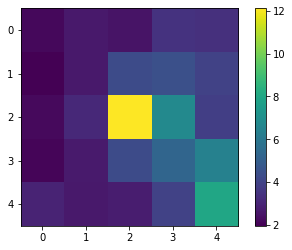

In [23]:
# Plotting an example of a 5-by-5 image
fig,ax = plt.subplots()
im = ax.imshow(event.IMG[1][40])
fig.colorbar(im)
plt.show()

## Least-Squares Fit

Text(0, 0.5, 'Flux (MJy/sr)')

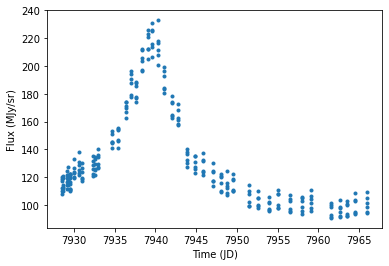

In [24]:
# Get raw photometry, error, and binned error
PTOT,PTOT_E,E_BIN = event.aperture_photometry()
# Flatten in chronological order for plotting purposes
time,ptot = event.chrono_flatten(PTOT)
# Plot our raw data so that we can make some parameter estimates.
plt.plot(time,ptot,'.')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (MJy/sr)')

In [25]:
# Make an initial guess for model parameters, which will be used as starting point for LM fit

# 5- parameter single lens model:
fb = 84.86
t0 = 7940.195
fs = 19.707
tE = 14.58
u0 = 0.1343
p0 = np.array([fb,t0,fs,tE])
# Estimate some bounds on these parameters. These do not have to be tight constraints.
bounds = ([0,7935,0,0],[140,7945,np.inf,np.inf])
# Fancy parameter labels
fancylabels = np.array([r'f_b',r'$t_0$',r'$f_s$',r'$t_E$'])

# 5- parameter single lens model:
#fb = 84.86
#t0 = 7940.195
#fs = 19.707
#tE = 14.58
#u0 = 0.1343
#p0 = np.array([fb,t0,fs,tE,u0])
# Estimate some bounds on these parameters. These do not have to be tight constraints.
#bounds = ([0,7935,0,0,-np.inf],[140,7945,np.inf,np.inf,np.inf])
# Fancy parameter labels
#fancylabels = np.array([r'f_b',r'$t_0$',r'$f_s$',r'$t_E$',r'$u_0$'])

# Binary lens model:
#s     = 0.815       # separation between the two lenses (in Einstein radius of total mass)
#q     = 0.0099      # mass ratio: Right-lens' mass divided by left-lens' mass
#rho   = 1e-6        # source radius in Einstein radii of the total mass.
#alpha = np.pi-2.561 # angle between lens axis and source trajectory (rad) VBBL_alpha = PI-OSU_alpha
#tE    = 14.58       # einstein radius crossing time
#t0    = 7940.195    # time of peak magnification
#u0    = 0.1343      # impact parameter
#fb    = 76          # baseline flux
#fs    = 21          # source flux
#p0 = np.asarray([s, q, rho, alpha, tE, t0, u0, fb, fs])
# Estimate some bounds on these parameters. These do not have to be tight constraints.
#bounds = ([0,0,0,-np.inf,0,7920,-np.inf,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf,7960,np.inf,np.inf,np.inf])
# Fancy parameter labels
#fancylabels = np.array([r'$s$', r'$q$', r'$\rho$', r'$alpha$', r'$t_E$', r'$t_0$', r'$u_0$', r'$f_b$', r'$f_s$'])

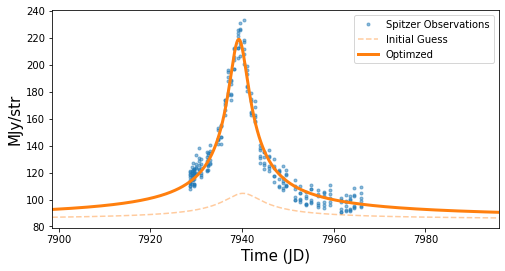

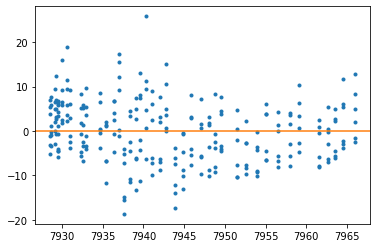

In [26]:
# Obtain raw photometry and errors
PTOT,PTOT_E,E_BIN = event.aperture_photometry()
# Perform LM fit and plot resulting curve
popt,perr,bestfit,resi_pre,timeplot,lcoptim = event.modelfit(MODELFUNC,p0,PTOT,makeplots=True,bounds=bounds)
plt.figure()
plt.plot(event.chrono_flatten()[0],resi_pre,'.')
plt.axhline(color='C1')

## Solving PLD Coefficients Analytically

RMS before  :  6.895853753023625
RMS after  :  1.6537521514710927


(<Figure size 576x648 with 3 Axes>,
 array([<AxesSubplot:ylabel='Photometry (MJy/str)'>,
        <AxesSubplot:ylabel='Photometry (MJy/str)'>,
        <AxesSubplot:xlabel='Time (JD)', ylabel='Residuals (MJy/str)'>],
       dtype=object))

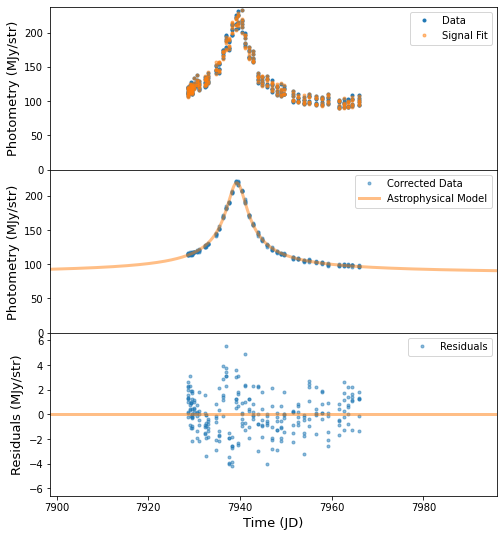

In [27]:
# Get fractional flux
PNORM = event.get_PNORM()
# Solve for PLD coefficients analytically (X)
Y, Astro, Ps, A, C, E, X = PLD.analytic_solution(event.TIMES, PTOT, PTOT_E, PNORM, popt, MODELFUNC)
# Get detector model and divide it out to get new best-fit
FIT, SYS, CORR, RESI = PLD.get_bestfit(A, Ps, X, PTOT, Astro)
# Flatten results for plotting
time,ptot,ptot_e,corr,resi,fit,sys = event.chrono_flatten(PTOT,PTOT_E,CORR,RESI,FIT,SYS)
# Compute RMS error before and after
RMS_before, RMS_after = PLD.get_RMS(resi_pre,label='RMS before',visual=True), PLD.get_RMS(resi,label='RMS after',visual=True)
# Plot corrected data, corrected model, and residuals
plot.plot_analytic_solution(time, ptot, fit, corr, resi, timeplot, lcoptim)

In [70]:
np.savetxt('s_popt_lsq.txt',popt)
np.savetxt('s_corr_lsq.txt',corr)

# MCMC Fit for PLD Parameters

In [28]:
load_chain_from_file = False

if load_chain_from_file:
    # Load chains from files
    path = os.path.join('data',EVENT_NAME,'mega_MCMC',MODELNAME)
    pos_chain = np.load(path+'/samplerchain.npy')
    lnp_chain = np.load(path+'/samplerlnpro.npy')
    pos_final = np.load(path+'/samplerposit.npy')
    pld_coeff_chain = np.load(path+'/PLD_chain.npy')
else:
    # Create wrapper object for PLD coefficient chain to make it mutable 
    PLD_chain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
    # Generate the MCMC sampler
    sampler = mcmc.get_MCMC_sampler(popt,MODELFUNC,event.TIMES,PTOT,PTOT_E,E_BIN,PNORM,PLD_chain,pool=Pool(),bounds=bounds)
    # Initialize the initial parameter positions for each walker by adding a random offset
    pos0 = [popt*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) for i in range(sampler.nwalkers)]
    
    # Run the MCMC
    
    #First burn-in:
    pos1,prob,state = mcmc.run_mcmc(sampler,pos0,300,label='first burn-in')
    sampler.reset()

    #Second burn-in
    #Continue from best spot from last time, and do quick burn-in to get walkers spread out
    pos2 = pos1[np.argmax(prob)]
    # slightly change position of walkers to prevent them from taking the same path
    pos2 = [pos2*(1+1e-6*np.random.randn(sampler.ndim))+1e-6*np.abs(np.random.randn(sampler.ndim)) for i in range(sampler.nwalkers)]
    pos2, prob, state = mcmc.run_mcmc(sampler,pos2,300,label='second burn-in')
    sampler.reset()
    
    #Run production that will be saved
    
    pos_final, prob, state = mcmc.run_mcmc(sampler,pos2,3000,label='production')

    pos_chain = sampler.chain
    lnp_chain = sampler.lnprobability
    pld_chain = PLD_chain.chain
    
    mcmc.save_results(EVENT_NAME,pos_chain,pos_final,lnp_chain,pld_chain,folder=MODELNAME)

# Get results from chain
popt_mcmc,pmax,std_hi,std_lo = mcmc.get_MCMC_results(pos_chain,lnp_chain)

Running MCMC first burn-in...


100%|█████████████████████████████████████████| 300/300 [01:05<00:00,  4.59it/s]


Mean burn-in acceptance fraction: 0.567
MCMC runtime = 1.09 min

Running MCMC second burn-in...


100%|█████████████████████████████████████████| 300/300 [00:49<00:00,  6.11it/s]


Mean burn-in acceptance fraction: 0.609
MCMC runtime = 0.82 min

Running MCMC production...


100%|███████████████████████████████████████| 3000/3000 [08:21<00:00,  5.98it/s]


Mean burn-in acceptance fraction: 0.594
MCMC runtime = 8.36 min



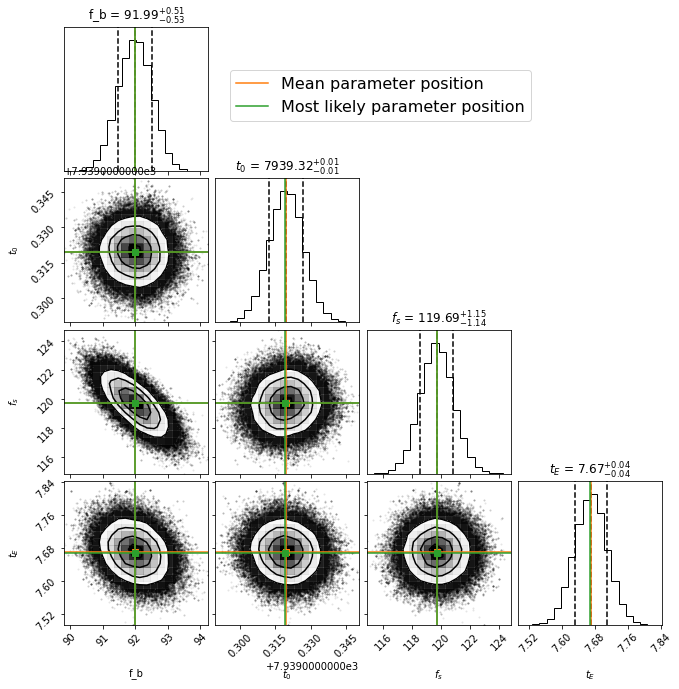

In [65]:
# Create corner plots to check for convergence
# 1d array of samples
samples = pos_chain.reshape((-1, len(popt_mcmc)))

# corner plot
fig = corner.corner(samples, labels=fancylabels, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, plot_datapoints=True, 
                    title_kwargs={"fontsize": 12})

corner.overplot_lines(fig, popt_mcmc, color="C1", label='Mean parameter position')
corner.overplot_points(fig, popt_mcmc[None], marker="s", color="C1")
corner.overplot_lines(fig, pmax, color="C2", label='Most likely parameter position')
corner.overplot_points(fig, pmax[None], marker="s", color="C2")

plt.legend(loc=(-2,3.5),fontsize=16)

plt.savefig('figs/singlecorners.png')

In [30]:
# Re-run MCMC if it does not look converged. This cell can be run repeatedly.
rerun_mcmc = False
if rerun_mcmc:
    # Create wrapper object for PLD coefficient chain to make it mutable 
    PLD_chain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
    # generate the MCMC sampler
    sampler = mcmc.get_MCMC_sampler(popt_mcmc,MODELFUNC,event.TIMES,PTOT,PTOT_E,E_BIN,PNORM,PLD_chain,pool=Pool(),bounds=bounds)
    # Initialize the initial parameter positions as the previous final parameter positions
    pos0 = pos_final
    # Run production
    pos_final,prob_final,state_final = mcmc.run_mcmc(sampler,pos0,1000,label='production')
    # Save results
    pos_chain = sampler.chain
    pld_chain = PLD_chain.chain
    lnp_chain = sampler.lnprobability
    mcmc.save_results(EVENT_NAME,pos_chain,pos_final,lnp_chain,pld_chain,folder=MODELNAME)
    # Get results from chain
    popt_mcmc,pmax,std_hi,std_lo = mcmc.get_MCMC_results(pos_chain,lnp_chain)

RMS after MCMC  :  1.5195196259141805


(<Figure size 576x648 with 3 Axes>,
 array([<AxesSubplot:ylabel='Photometry (MJy/str)'>,
        <AxesSubplot:ylabel='Photometry (MJy/str)'>,
        <AxesSubplot:xlabel='Time (JD)', ylabel='Residuals (MJy/str)'>],
       dtype=object))

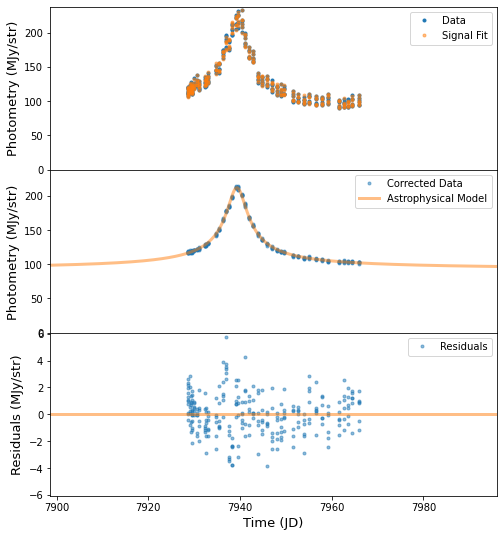

In [36]:
Y, Astro, Ps, A, C, E, X = PLD.analytic_solution(event.TIMES, PTOT, PTOT_E, PNORM, pmax, MODELFUNC)
# Get detector model and divide it out to get new best-fit
FIT_MCMC, SYS_MCMC, CORR_MCMC, RESI_MCMC = PLD.get_bestfit(A, Ps, X, PTOT, Astro)
# Flatten results for plotting
time,corr_mcmc,resi_mcmc,fit_mcmc,sys_mcmc = event.chrono_flatten(CORR_MCMC,RESI_MCMC,FIT_MCMC,SYS_MCMC)
# Compute RMS error before and after
RMS_mcmc = PLD.get_RMS(resi_mcmc,label='RMS after MCMC',visual=True)
# Plot corrected data, corrected model, and residuals
plot.plot_analytic_solution(time, ptot, fit_mcmc, corr_mcmc, resi_mcmc, timeplot, MODELFUNC(timeplot,*popt_mcmc))

In [69]:
np.savetxt('single_pars.txt',pmax)
np.savetxt('single_corr.txt',corr_mcmc)

# Analysis

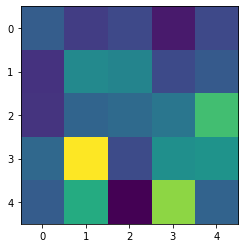

In [62]:
plt.imshow(X[2].reshape((5,5)))

In [46]:
def bic_prob(bics):
    bicmin = np.min(bics)
    tmp = np.exp(-0.5*(bics-bicmin))
    return tmp/tmp.sum()

In [13]:
# Compute BIC
bic = mcmc.get_BIC(popt_mcmc, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, X)
print(bic)

1964.5946932049023


In [49]:
p1,p2 = bic_prob([bic,1229.4738351327953])
print(p2/p1)

4.2605542182510495e+159


In [40]:
def resi_prob(resimax,std):
    ratio = resimax/std
    norm = (2*np.pi)**0.5*std
    prob = np.exp(-0.5*ratio**2)/norm
    return prob

3.7852107872072076
1.5191712937380029
0.0002032621831382385


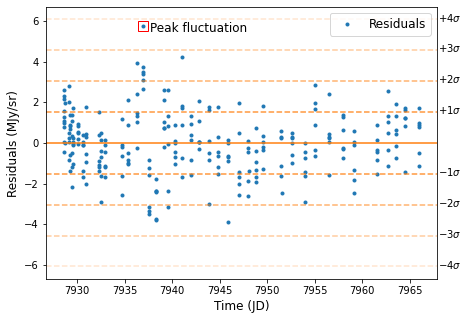

In [68]:
resi_corr = corr_mcmc-MODELFUNC(time,*popt_mcmc)
std = resi_corr.std()
indmax = np.argmax(np.abs(resi_corr))
timemax,resimax = time[indmax],resi_corr[indmax]

fig,ax = plt.subplots(figsize=(7,5))
ax.plot(time,resi_corr,'.',label='Residuals')
ax.plot(timemax,resimax,marker='s',fillstyle='none',color='red',markersize=10)
ax.text(timemax+0.7,resimax-0.3,'Peak fluctuation',fontsize=12)

ax.axhline(y=0,color='C1')
#ax.text(time[-1]+2.1,-0.1,r'best fit')
for i in range(1,5):
    ax.axhline(y=i*std,color='C1',ls='--',alpha=1-0.2*i)
    ax.axhline(y=-i*std,color='C1',ls='--',alpha=1-0.2*i)
    ax.text(time[-1]+2,i*std-0.1,r'$+%d\sigma$'%i)
    ax.text(time[-1]+2,-i*std-0.1,r'$-%d\sigma$'%i)
    
ax.set_ylabel('Residuals (MJy/sr)',fontsize=12)
ax.set_xlabel('Time (JD)',fontsize=12)

ax.legend(fontsize=12)

plt.savefig('figs/resimax.png')

print(resimax/std)
print(std)
print(resi_prob(resimax,std))

# Beyond this point is outdated

In [15]:
assert False

AssertionError: 

In [ ]:
load_chain_from_file = False

if load_chain_from_file:
    # Load chains from files
    path = os.path.join('data',EVENT_NAME,'mega_MCMC')
    chain = np.load(path+'/samplerchain.npy')
    lnprob = np.load(path+'/samplerlnpro.npy')
    posit = np.load(path+'/samplerposit.npy')
    PLD_chain = np.load(path+'/PLD_chain.npy')
else:
    # Create wrapper object for PLD coefficient chain to make it mutable 
    PLD_chain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
    # generate the MCMC sampler
    sampler = mcmc.get_MCMC_sampler(popt,MODELFUNC,event.TIMES,PTOT,PTOT_E,E_BIN,PNORM,PLD_chain,pool=Pool(),bounds=bounds)
    # Initialize the initial parameter positions for each walker by adding a random offset
    pos0 = [popt*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) for i in range(sampler.nwalkers)]
    # Run the MCMC
    chain,posit,lnprob = mcmc.run_MCMC(sampler,pos0)
    # Retrieve PLD coefficient chain from the wrapper object
    PLD_chain = PLD_chain.chain
    # Save chains to files
    #mcmc.save_chain(EVENT_NAME,chain,posit,lnprob,PLD_chain)

In [ ]:
rerun_mcmc = True
if rerun_mcmc:
    PLD_chain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
    # generate the MCMC sampler
    sampler = mcmc.get_MCMC_sampler(popt_mcmc,MODELFUNC,event.TIMES,PTOT,PTOT_E,E_BIN,PNORM,PLD_chain,pool=Pool(),bounds=bounds)
    # Initialize the initial parameter positions for each walker by adding a random offset
    pos0 = [popt_mcmc*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) for i in range(sampler.nwalkers)]
    # Run the MCMC
    chain,posit,lnprob = mcmc.run_MCMC(sampler,pos0,)
    # Retrieve PLD coefficient chain from the wrapper object
    PLD_chain = PLD_chain.chain
    #mcmc.save_chain(EVENT_NAME,chain,posit,lnprob,PLD_chain)

In [ ]:
samples = chain.reshape((-1, len(popt_mcmc)))[500:]
fancylabels = np.array([r'$s$', r'$q$', r'$\rho$', r'$alpha$', r'$t_E$', r'$t_0$', r'$u_0$', r'$f_b$', r'$f_s$'])

# corner plot
fig = corner.corner(samples, labels=fancylabels, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, plot_datapoints=True, 
                    title_kwargs={"fontsize": 12})

corner.overplot_lines(fig, popt_mcmc, color="C1", label='Mean parameter position')
corner.overplot_points(fig, popt_mcmc[None], marker="s", color="C1")
corner.overplot_lines(fig, pmax, color="C2", label='Most likely parameter position')
corner.overplot_points(fig, pmax[None], marker="s", color="C2")

plt.legend(loc=(-5,7),fontsize=16)

#plt.savefig('badcorners.png')

In [ ]:
lnprob_av = np.mean(lnprob)
popt_mcmc = np.mean(chain,axis=(0,1))
print(popt_mcmc.shape)

In [ ]:
# Optimal parameters are the average position of the walkers
#popt_mcmc = np.mean(posit,axis=0)
# Solve for PLD coefficients analytically
Y, Astro, Ps, A, C, E, X = PLD.analytic_solution(event.TIMES, PTOT, PTOT_E, PNORM, popt_mcmc, MODELFUNC)
# Get detector model and divide it out to get new best-fit
FIT_MCMC, SYS_MCMC, CORR_MCMC, RESI_MCMC = PLD.get_bestfit(A, Ps, X, PTOT, Astro)
# Flatten results for plotting
time,corr_mcmc,resi_mcmc,fit_mcmc,sys_mcmc = event.chrono_flatten(CORR_MCMC,RESI_MCMC,FIT_MCMC,SYS_MCMC)
# Compute RMS error before and after
RMS_mcmc = PLD.get_RMS(resi_mcmc,label='RMS after MCMC',visual=True)
# Plot corrected data, corrected model, and residuals
plot.plot_analytic_solution(time, ptot, fit_mcmc, corr_mcmc, resi_mcmc, timeplot, MODELFUNC(timeplot,*popt_mcmc))

# Error Analysis

In [ ]:
popt_mcmc,pmax,std_hi,std_lo = mcmc.get_MCMC_results(chain,lnprob)
lnlike = mcmc.lnlike(popt_mcmc, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, dudchain)
bic = popt_mcmc.size*np.log(ptot.size)-lnlike
bic_single = 2030.5618472356946
print(bic)
print(bic_single)
print(np.exp(-0.5*bic))
print(np.exp(-0.5*bic_single))

In [ ]:
posit = chain.reshape(-1,len(p0))

# Get the percentile
percs = np.percentile(posit, [16, 50, 84],axis=0)
(MCMC_Results) = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*percs))))

popt_mcmc = MCMC_Results[:,0]
std_hi = MCMC_Results[:,1]
std_lo = MCMC_Results[:,2]

# Get most probable params
probs = lnprob.flatten()
p_max = posit[np.argmax(probs)]

print(popt_mcmc)
print(p_max)
print(MCMC_Results)

# Extra Plots

In [ ]:
print(posit.shape)
nbins=20
i = 2

pmin = posit.min(axis=0)
pmax = posit.max(axis=0)
bins = np.linspace(pmin,pmax,nbins)
aa,bb = np.histogram(posit[:,i],bins[:,i])
cents = 0.5*(bb[1:]+bb[:-1])

fig,ax = plt.subplots(figsize=(5,5))
ax.bar(cents,aa,width=bb[1]-bb[0],color='powderblue',edgecolor='black')

ax.axvline(popt_mcmc[i],color='C1',label='Mean')
ax.axvline(popt_mcmc[i]-std_lo[i],color='C1',ls='--')
ax.axvline(popt_mcmc[i]+std_hi[i],color='C1',ls='--')
ax.axvline(popt_mcmc[i]-2*std_lo[i],color='C1',ls='--')
ax.axvline(popt_mcmc[i]+2*std_hi[i],color='C1',ls='--')
ax.text(popt_mcmc[i]+0.0001,24850,'Mean',size='large')
ax.text(popt_mcmc[i]-std_lo[i],24900,r'$-\sigma$',size='x-large')
ax.text(popt_mcmc[i]+std_hi[i],24900,r'$+\sigma$',size='x-large')
ax.text(popt_mcmc[i]-2*std_lo[i],24900,r'$-2\sigma$',size='x-large')
ax.text(popt_mcmc[i]+2*std_hi[i],24900,r'$+2\sigma$',size='x-large')
#ax.set_xticks(bb)
ax.set_xlabel(r'Angular lens separation $s$, radians',size='xx-large')
ax.set_ylabel('Number of samples',size='xx-large')
ax.set_title(r'$s = %.4f_{-%.4f}^{+%.4f}$' % (popt_mcmc[i],std_lo[i],std_hi[i]),size='x-large')
ax.set_xlim(popt_mcmc[i]-3*std_lo[i],popt_mcmc[i]+3*std_hi[i])
plt.tight_layout()
plt.savefig('errors.png',dpi=300)

In [ ]:
s, q, rho, alpha, tE, t0, u0, fb, fs = p0
p0_single = np.array([9.20263259e+01, 7.93931983e+03, 1.19630450e+02, 7.66795064e+00])
fb_s,t0_s,fs_s,tE_s = p0_single
timeplot = np.linspace(t0-tE,t0+tE,1000)
fig,ax = plt.subplots(1,2,figsize=(10,3))

y1 = models.single_lens(timeplot,*p0_single)
y2 = MODELFUNC(timeplot,*p0)

w1 = 1.7
h1 = 10

w2 = 1.7
h2 = 12

ylens1 = 130
ylens2 = 130

ax[0].add_patch(patches.Ellipse((t0_s,ylens1),w1,h1,color='darkgreen'))
ax[0].text(t0_s-3,ylens1-15,'Single lens',size='large')
ax[0].text(t0_s-15,ylens1+30,'Source',size='large')
source_ts = np.linspace(t0_s-14,t0_s+14,11)
for t in source_ts:
    ax[0].add_patch(patches.Ellipse((t,ylens1+20),w1,h1,color='lightgreen',fill=False))
    
ax[1].add_patch(patches.Ellipse((t0+0.5,ylens2),w2,h2,color='darkorange'))
ax[1].add_patch(patches.Ellipse((t0-2.2,ylens2),w2/3,h2/3,color='darkorange'))
ax[1].text(t0-4,ylens2-15,'Binary lens',size='large')
ax[1].text(t0-15,ylens2+40,'Source',size='large')
source_ts = np.linspace(t0-14,t0+14,11)
for t in source_ts:
    ax[1].add_patch(patches.Ellipse((t,ylens2+30),w2,h2,color='moccasin',fill=False))

ax[0].plot(timeplot,y1,color='C2',lw=2,label='Single-lens light curve')
ax[1].plot(timeplot,y2,color='C1',lw=2,label='Binary-lens light curve')
ax[0].xaxis.set_visible(False)
#ax[0].yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
#ax[0].legend(fontsize=14,loc=8)
#ax[1].legend(fontsize=14,loc=8)
ax[0].yaxis.set_ticks([])
ax[0].set_ylabel('Brightness',size='x-large')
ax[0].text(7954,93,'Time',size='x-large')

if False:
    ax[0].axvline(x=t0_s,ls='--',color='lightgreen')
    ax[0].text(t0_s,110,r'$t_0$',fontsize=16)
    ax[0].plot([t0_s,t0_s+tE_s],[models.single_lens(t0_s-tE_s,*p0_single),models.single_lens(t0_s+tE_s,*p0_single)],color='lightgreen',ls='--')
    ax[0].text(t0_s+1,130,r'$t_E$',fontsize=16)
ss
    ax[1].axvline(x=t0,ls='--',color='moccasin')
    ax[1].text(t0,110,r'$t_0$',fontsize=16)
    ax[1].plot([t0,t0+tE],[MODELFUNC([t0-tE],*p0),MODELFUNC([t0+tE],*p0)],color='moccasin',ls='--')
    ax[1].text(t0+1,130,r'$t_E$',fontsize=16)

#fig.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig('comparemodels.png',dpi=300)

In [ ]:
dudchain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
lnlike = mcmc.lnlike(popt_mcmc, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, dudchain)

bic = popt_mcmc.size*np.log(ptot.size)-lnlike

In [ ]:
timeplot = np.linspace(time[0],time[-1],1000)

corr_single = np.loadtxt('single_corr.txt')
popt_single = np.loadtxt('single_pars.txt')

print(bic/2030.5618472356946)

fig,ax = plt.subplots(figsize=(9,6))
ax.plot(timeplot,MODELFUNC(timeplot,*popt_mcmc),color='C1',alpha=0.5,label='Best-fit binary-lens curve')
ax.plot(timeplot,models.single_lens(timeplot,*popt_single),color='C2',alpha=0.5,label='Best-fit single-lens curve')
ax.plot(time,ptot,'.',color='c',alpha=0.7,label='Raw photometry')
ax.plot(time,corr_mcmc,'.',color='C1',alpha=0.5,label='Corrected photometry for binary-lens MCMC fit')
ax.plot(time,corr_single,'.',color='C2',alpha=0.5,label='Corrected photometry for single-lens MCMC fit')
ax.set_ylim(fb+10,240)
ax.legend(fontsize=11)
ax.set_xlabel('Time (JD)',size='xx-large')
ax.set_ylabel('Photometry (MJy/sr)',size='xx-large')
ax.text(7949,180,'Binary-lens RMS: %.2f'%0.6893780883159933,fontsize='xx-large')
ax.text(7949,170,'Single-lens RMS: %.2f'%1.5189632473783468,fontsize='xx-large')
ax.text(7949,160,'Binary-lens BIC: %.2f'%bic,fontsize='xx-large')
ax.text(7949,150,'Single-lens BIC: %.2f'%2030.5618472356946,fontsize='xx-large')
plt.savefig('double_single_MCMC_fits.png',dpi=400)

In [ ]:
timeplot = np.linspace(time[0],time[-1],1000)
bf = MODELFUNC(time,*popt_mcmc)
fig,ax = plt.subplots(figsize=(9,6))
ax.axhline(color='C1',alpha=0.7,label='Best-fit binary-lens curve')
ax.plot(time,ptot-bf,'.',color='c',alpha=0.5,label='Raw photometry')
#ax.plot(time,corr-bf,'.',color='y',alpha=0.5,label='Raw photometry corrected for LM fit')
ax.plot(time,corr_mcmc-bf,'.',color='m',alpha=0.5,label='Raw photometry corrected for MCMC fit')
ax.legend(fontsize='large')
ax.set_xlabel('Time (JD)',size='xx-large')
ax.set_ylabel('Residuals (MJy/sr)',size='xx-large')

In [ ]:
lnlike_lm = mcmc.lnlike(popt, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, dudchain)
bic_lm = popt.size*np.log(ptot.size)-lnlike
rms_corr = PLD.get_RMS(corr-bf)
rms_pre = PLD.get_RMS(resi_pre)
print(bic_lm)

timeplot = np.linspace(time[0],time[-1],1000)
bf = MODELFUNC(time,*popt)
fig,ax = plt.subplots(2,figsize=(8,9))

ax[0].plot(timeplot,MODELFUNC(timeplot,*p0),color='C1',alpha=0.4,label='Initital guess for binary-lens curve',ls='--')
ax[0].plot(timeplot,MODELFUNC(timeplot,*popt),color='C1',alpha=0.7,label='Least-squares best-fit binary-lens curve')
ax[0].plot(time,ptot,'.',color='c',alpha=0.5,label='Raw photometry')
ax[0].plot(time,corr,'.',color='m',alpha=0.5,label='Photometry corrected for least-squares fit')
ax[0].legend(fontsize='large')
ax[0].set_ylabel('Photometry (MJy/sr)',size='xx-large')
ax[0].xaxis.set_visible(False)

ax[0].text(7943,230,'Raw photometry RMS error: %.2f'%rms_pre,size=16)
ax[0].text(7943,210,'Corrected RMS error: %.2f'%rms_corr,size=16)

ax[1].axhline(color='C1',alpha=0.7,label='Least-squares best-fit binary-lens curve')
ax[1].plot(time,ptot-bf,'.',color='c',alpha=0.5,label='Raw photometry')
ax[1].plot(time,corr-bf,'.',color='m',alpha=0.5,label='Photometry corrected for least-squares fit')
ax[1].legend(fontsize='large')
ax[1].set_xlabel('Time (JD)',size='xx-large')
ax[1].set_ylabel('Residuals (MJy/sr)',size='xx-large')

fig.tight_layout()
plt.subplots_adjust(hspace=0)

plt.savefig('lsq_fit.png')

In [ ]:
print(popt_mcmc)

In [ ]:
_,fit = event.chrono_flatten(FIT)
print(fit.shape)
plt.plot(time,ptot-fit,'.')
#plt.plot(time,ptot,'.')

In [ ]:
dudchain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
bic = mcmc.lnlike(popt_mcmc, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, dudchain)
print(bic)

In [ ]:
np.shape(PTOT/CORR_MCMC)
print((PTOT/CORR_MCMC)[0])

In [ ]:
D = PTOT/CORR_MCMC
fig,ax = plt.subplots(figsize=(4,3))
colors=['blue','purple','green','cyan','magenta','darkorange']
for i in range(len(PTOT)):
    ax.plot(event.TIMES[i],D[i],'.',color=colors[i])
#ax.set_xlabel('Time (JD)',size='x-large')
#ax.set_ylabel('Instrumental Noise',size='x-large')
ax.axhline(y=1,color='black',lw=1,ls=(0,(5,5)))
ax.xaxis.set_ticks([])
ax.set_xlabel('Instrumental Noise',size='xx-large')
ax.yaxis.set_visible(False)
plt.savefig('instrumental_noise.png')

In [ ]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(timeplot,MODELFUNC(timeplot,*p0),color='dodgerblue')
#plt.xlabel('Time (JD)',size='x-large')
#plt.ylabel('Photometry',size='x-large')
ax.xaxis.set_ticks([])
ax.set_xlabel('Astrophysical Signal',size='xx-large')
ax.yaxis.set_visible(False)
plt.savefig('astrophysical_model.png')

In [ ]:
fig,ax = plt.subplots(figsize=(4,3))
for i in range(len(PTOT)):
    ax.plot(event.TIMES[i],PTOT[i],'.',color=colors[i])
#plt.xlabel('Time (JD)',size='x-large')
#plt.ylabel('Photometry',size='x-large')
ax.xaxis.set_ticks([])
ax.set_xlabel('Raw Photometry',size='xx-large')
ax.yaxis.set_visible(False)
plt.savefig('raw_photometry.png')

In [33]:
results = np.array([popt_mcmc,pmax,std_hi,std_lo]).T
print(fancylabels)
print(results)

['f_b' '$t_0$' '$f_s$' '$t_E$']
[[9.19929080e+01 9.19802910e+01 5.12927844e-01 5.27377418e-01]
 [7.93931965e+03 7.93931929e+03 7.28170046e-03 7.38372794e-03]
 [1.19687800e+02 1.19703698e+02 1.14699393e+00 1.14054451e+00]
 [7.67064692e+00 7.66803428e+00 3.88100550e-02 3.96368153e-02]]
